## CHURN PREDICTION WITH PYSPARK



# INSTRUCCIONES DE INSTALACIÓN Y CONFIGURACIÓN

https://www.youtube.com/watch?v=uhVYTNEe_-A

## OPERATIONS IN SPARK

https://spark.apache.org/docs/2.1.0/ml-features.html

## ORDEN DE ANÁLISIS

1. Carga y tratamiento inicial: Spark Core.
2. Consulta y análisis exploratorio: Spark SQL.
3. Machine learning: MLlib.
4. ...

## NOTES IN DATA PREPARATION

https://dataplatform.cloud.ibm.com/exchange/public/entry/view/972c1d5333a2d12ccdbd2437298e8567



## 1. Carga y tratamiento inicial: Spark Core.

**SparkContext vs. SparkSession**
* Para poder hacer uso de Spark Core, lo primero que hay que hacer es crear un objeto de tipo SparkContext.
* Para poder hacer uso de Spark SQL, lo primero que hay que hacer es crear un objeto de tipo SparkSession.

Spark SQL está construido “sobre” Spark Core, por lo que un objeto de tipo SparkSession SIEMPRE contiene un objeto de tipo SparkContext.
En versiones anteriores de Spark había que crear explícitamente un SparkContext y, luego, pasarlo como parámetro en la creación de un SQLContext o HiveContext.
A partir de la versión 2.0, SparkSession nos da un único punto de acceso a todo.

In [157]:
import warnings
warnings.filterwarnings('ignore') # Disable warnings

In [158]:
import os
import sys

APP_NAME = 'pyspark_python'
MASTER = 'local[*]'


In [159]:
# Configuration properties of Apache Spark
#sc.stop()
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [160]:
#modelDataFile = "../../churn_dataset_anom/churn.all"
modelDataFile = "churn.all"

CV_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(modelDataFile)
CV_data.take(1)

[Row(state='KS', account_length=128, area_code=415, phone_number=' 382-4657', international_plan=' no', voice_mail_plan=' yes', number_vmail_messages=25, total_day_minutes=265.1, total_day_calls=110, total_day_charge=45.07, total_eve_minutes=197.4, total_eve_calls=99, total_eve_charge=16.78, total_night_minutes=244.7, total_night_calls=91, total_night_charge=11.01, total_intl_minutes=10.0, total_intl_calls=3, total_intl_charge=2.7, number_customer_service_calls=1, Churn=' False.')]

## Inspección de estructura

En primer lugar, Spark SQL pone a nuestra disposición herramientas suficientes para poder
tener una visión clara de la estructura que siguen nuestros datos:
* Nombres de campos.
* Tipos.
* ...

**Inspección de estructura**

* df.dtypes Listado de columnas con nombre y tipo
* df.schema Visualización del esquema como StructType
* df.printSchema() Visualización “formateada” del esquema
* df.columns Listado de columnas del DataFrame

df is the name of the dataframe

In [161]:
CV_data.toPandas().shape

(5000, 21)

In [162]:
CV_data.dtypes

[('state', 'string'),
 ('account_length', 'int'),
 ('area_code', 'int'),
 ('phone_number', 'string'),
 ('international_plan', 'string'),
 ('voice_mail_plan', 'string'),
 ('number_vmail_messages', 'int'),
 ('total_day_minutes', 'double'),
 ('total_day_calls', 'int'),
 ('total_day_charge', 'double'),
 ('total_eve_minutes', 'double'),
 ('total_eve_calls', 'int'),
 ('total_eve_charge', 'double'),
 ('total_night_minutes', 'double'),
 ('total_night_calls', 'int'),
 ('total_night_charge', 'double'),
 ('total_intl_minutes', 'double'),
 ('total_intl_calls', 'int'),
 ('total_intl_charge', 'double'),
 ('number_customer_service_calls', 'int'),
 ('Churn', 'string')]

In [163]:
my_schema = CV_data.schema 

In [164]:
CV_data.printSchema() 
print("Number of fields: %3g" % len(CV_data.schema))

root
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: integer (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- Churn: string (nul

In [165]:
CV_data.columns


['state',
 'account_length',
 'area_code',
 'phone_number',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'Churn']

## Inspección de contenido


* df.show(n) Muestra n filas en formato tabla
* df.head(n) Muestra n filas como lista de objetos Row
* df.take(n) Muestra n filas como lista de objetos Row
* df.first() Muestra la primera fila como objeto Row
* df.count() Recuperación del número de filas
* df.distinct() Recuperación de las filas únicas
* df.describe() Cálculo de estadísticos básicos

In [166]:
CV_data.show(2)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|  Churn|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+------------

In [167]:
CV_data.head(2)

[Row(state='KS', account_length=128, area_code=415, phone_number=' 382-4657', international_plan=' no', voice_mail_plan=' yes', number_vmail_messages=25, total_day_minutes=265.1, total_day_calls=110, total_day_charge=45.07, total_eve_minutes=197.4, total_eve_calls=99, total_eve_charge=16.78, total_night_minutes=244.7, total_night_calls=91, total_night_charge=11.01, total_intl_minutes=10.0, total_intl_calls=3, total_intl_charge=2.7, number_customer_service_calls=1, Churn=' False.'),
 Row(state='OH', account_length=107, area_code=415, phone_number=' 371-7191', international_plan=' no', voice_mail_plan=' yes', number_vmail_messages=26, total_day_minutes=161.6, total_day_calls=123, total_day_charge=27.47, total_eve_minutes=195.5, total_eve_calls=103, total_eve_charge=16.62, total_night_minutes=254.4, total_night_calls=103, total_night_charge=11.45, total_intl_minutes=13.7, total_intl_calls=3, total_intl_charge=3.7, number_customer_service_calls=1, Churn=' False.')]

In [168]:
CV_data.take(2)

[Row(state='KS', account_length=128, area_code=415, phone_number=' 382-4657', international_plan=' no', voice_mail_plan=' yes', number_vmail_messages=25, total_day_minutes=265.1, total_day_calls=110, total_day_charge=45.07, total_eve_minutes=197.4, total_eve_calls=99, total_eve_charge=16.78, total_night_minutes=244.7, total_night_calls=91, total_night_charge=11.01, total_intl_minutes=10.0, total_intl_calls=3, total_intl_charge=2.7, number_customer_service_calls=1, Churn=' False.'),
 Row(state='OH', account_length=107, area_code=415, phone_number=' 371-7191', international_plan=' no', voice_mail_plan=' yes', number_vmail_messages=26, total_day_minutes=161.6, total_day_calls=123, total_day_charge=27.47, total_eve_minutes=195.5, total_eve_calls=103, total_eve_charge=16.62, total_night_minutes=254.4, total_night_calls=103, total_night_charge=11.45, total_intl_minutes=13.7, total_intl_calls=3, total_intl_charge=3.7, number_customer_service_calls=1, Churn=' False.')]

In [169]:
CV_data.first

<bound method DataFrame.first of DataFrame[state: string, account_length: int, area_code: int, phone_number: string, international_plan: string, voice_mail_plan: string, number_vmail_messages: int, total_day_minutes: double, total_day_calls: int, total_day_charge: double, total_eve_minutes: double, total_eve_calls: int, total_eve_charge: double, total_night_minutes: double, total_night_calls: int, total_night_charge: double, total_intl_minutes: double, total_intl_calls: int, total_intl_charge: double, number_customer_service_calls: int, Churn: string]>

In [170]:
CV_data.count()
print("Total number of records: " + str(CV_data.count()))

Total number of records: 5000


In [171]:
CV_data.distinct()

DataFrame[state: string, account_length: int, area_code: int, phone_number: string, international_plan: string, voice_mail_plan: string, number_vmail_messages: int, total_day_minutes: double, total_day_calls: int, total_day_charge: double, total_eve_minutes: double, total_eve_calls: int, total_eve_charge: double, total_night_minutes: double, total_night_calls: int, total_night_charge: double, total_intl_minutes: double, total_intl_calls: int, total_intl_charge: double, number_customer_service_calls: int, Churn: string]

In [172]:
CV_data.describe()

DataFrame[summary: string, state: string, account_length: string, area_code: string, phone_number: string, international_plan: string, voice_mail_plan: string, number_vmail_messages: string, total_day_minutes: string, total_day_calls: string, total_day_charge: string, total_eve_minutes: string, total_eve_calls: string, total_eve_charge: string, total_night_minutes: string, total_night_calls: string, total_night_charge: string, total_intl_minutes: string, total_intl_calls: string, total_intl_charge: string, number_customer_service_calls: string, Churn: string]

In [173]:
type(CV_data)

pyspark.sql.dataframe.DataFrame

In [174]:
CV_data.cache

<bound method DataFrame.cache of DataFrame[state: string, account_length: int, area_code: int, phone_number: string, international_plan: string, voice_mail_plan: string, number_vmail_messages: int, total_day_minutes: double, total_day_calls: int, total_day_charge: double, total_eve_minutes: double, total_eve_calls: int, total_eve_charge: double, total_night_minutes: double, total_night_calls: int, total_night_charge: double, total_intl_minutes: double, total_intl_calls: int, total_intl_charge: double, number_customer_service_calls: int, Churn: string]>

In [175]:
CV_data.show

<bound method DataFrame.show of DataFrame[state: string, account_length: int, area_code: int, phone_number: string, international_plan: string, voice_mail_plan: string, number_vmail_messages: int, total_day_minutes: double, total_day_calls: int, total_day_charge: double, total_eve_minutes: double, total_eve_calls: int, total_eve_charge: double, total_night_minutes: double, total_night_calls: int, total_night_charge: double, total_intl_minutes: double, total_intl_calls: int, total_intl_charge: double, number_customer_service_calls: int, Churn: string]>

In [176]:
# you can see that is imposible to see clearly the data, so we transform the data to a python dataframe with pandas
import pandas as pd
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [177]:
#summary statistics
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
state,5000,None,None,AK,WY
account_length,5000,100.2586,39.69455954726711,1,243
area_code,5000,436.9114,42.20918233103564,408,510
phone_number,5000,None,None,327-1058,422-9964
international_plan,5000,None,None,no,yes
voice_mail_plan,5000,None,None,no,yes
number_vmail_messages,5000,7.7552,13.54639339140803,0,52
total_day_minutes,5000,180.2888999999998,53.89469916893229,0.0,351.5
total_day_calls,5000,119.834,442.7395429646885,0,9999


In [178]:
#check for NA'S
df_complete = CV_data.dropna()
print("Number of records with complete data: %3g" % df_complete.count())
print("Total data: %3g" % CV_data.count())

Number of records with complete data: 5000
Total data: 5000


In [179]:
# TRANSFORM CATEGORICAL VARIABLES TO BINARY

def binary_transformation(CV_data, var):    
    from pyspark.ml.feature import StringIndexer
    new_var = var + '_'
    indexer = StringIndexer(inputCol= var, outputCol=new_var).fit(CV_data)
    CV_data = indexer.transform(CV_data)
    CV_data = CV_data.drop(var)
    return(CV_data)


In [58]:
# count the distribution OF CHURNERS
CV_data.groupBy('Churn').count().show()

+-------+-----+
|  Churn|count|
+-------+-----+
| False.| 4293|
|  True.|  707|
+-------+-----+



In [59]:
##
var = "Churn"
CV_data = binary_transformation(CV_data, var)
##
CV_data.groupBy('Churn_').count().show()

+------+-----+
|Churn_|count|
+------+-----+
|   0.0| 4293|
|   1.0|  707|
+------+-----+



In [60]:
CV_data.groupBy('phone_number').count().show()

+------------+-----+
|phone_number|count|
+------------+-----+
|    381-2709|    1|
|    387-9301|    1|
|    419-8987|    1|
|    417-2716|    1|
|    387-5891|    1|
|    406-4560|    1|
|    374-8187|    1|
|    339-6477|    1|
|    334-4354|    1|
|    350-9318|    1|
|    363-7802|    1|
|    389-6955|    1|
|    403-1128|    1|
|    386-2970|    1|
|    360-1320|    1|
|    344-5766|    1|
|    336-4960|    1|
|    340-9449|    1|
|    410-3396|    1|
|    420-1947|    1|
+------------+-----+
only showing top 20 rows



In [61]:
CV_data.groupBy('voice_mail_plan').count().show()

+---------------+-----+
|voice_mail_plan|count|
+---------------+-----+
|             no| 3677|
|            yes| 1323|
+---------------+-----+



In [62]:
##
var = "voice_mail_plan"
CV_data = binary_transformation(CV_data, var)
##
CV_data.groupBy('voice_mail_plan_').count().show()

+----------------+-----+
|voice_mail_plan_|count|
+----------------+-----+
|             0.0| 3677|
|             1.0| 1323|
+----------------+-----+



In [63]:
CV_data.groupBy('international_plan').count().show()

+------------------+-----+
|international_plan|count|
+------------------+-----+
|                no| 4527|
|               yes|  473|
+------------------+-----+



In [64]:
##
var = "international_plan"
CV_data = binary_transformation(CV_data, var)
##
CV_data.groupBy('international_plan_').count().show()

+-------------------+-----+
|international_plan_|count|
+-------------------+-----+
|                0.0| 4527|
|                1.0|  473|
+-------------------+-----+



In [65]:
CV_data.groupBy('state').count().show()

+-----+-----+
|state|count|
+-----+-----+
|   AZ|   89|
|   SC|   91|
|   LA|   82|
|   MN|  125|
|   NJ|  112|
|   DC|   88|
|   OR|  114|
|   VA|  118|
|   RI|   99|
|   WY|  115|
|   KY|   99|
|   NH|   95|
|   MI|  103|
|   NV|   90|
|   WI|  106|
|   ID|  119|
|   CA|   52|
|   NE|   88|
|   CT|   99|
|   MT|   99|
+-----+-----+
only showing top 20 rows



In [66]:
CV_data.groupBy('area_code').count().show()

+---------+-----+
|area_code|count|
+---------+-----+
|      415| 2495|
|      510| 1246|
|      408| 1259|
+---------+-----+



In [67]:

# Create a set of dummy variables from the sex variable
var = 'area_code'
CV_data_2 = CV_data.toPandas()
    
df_sex = pd.get_dummies(CV_data_2[var])
df_sex.head()

##
import numpy as np


In [68]:

### OJO SIEMPRE ES N-1 CON LAS DICOTOMICAS....

def from_categorical_to_dummies(CV_data, var):
    # Create a set of dummy variables from the sex variable
    CV_data_2 = CV_data.toPandas()
    
    df_sex = pd.get_dummies(CV_data_2[var])
    #columns and tranformation
    col = list(df_sex.columns)
    # Join the dummy variables to the main dataframe
    df_new = pd.concat([CV_data_2, df_sex], axis=1)
    df_new[col] = df_new[col].apply(pd.to_numeric, downcast='float')

    CV_data = spark.createDataFrame(df_new) #schema=mySchema
    return(CV_data)

var = 'area_code'
CV_data =from_categorical_to_dummies(CV_data, var)
CV_data.toPandas().head()

   

,state,account_length,area_code,phone_number,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn_,voice_mail_plan_,international_plan_,408,415,510
0,KS,128,415,382-4657,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,0.0,1.0,0.0,0,1,0
1,OH,107,415,371-7191,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,0.0,1.0,0.0,0,1,0
2,NJ,137,415,358-1921,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,0.0,0.0,0.0,0,1,0
3,OH,84,408,375-9999,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,0.0,0.0,1.0,1,0,0
4,OK,75,415,330-6626,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,0.0,0.0,1.0,0,1,0


In [69]:
CV_data.printSchema()

root
 |-- state: string (nullable = true)
 |-- account_length: long (nullable = true)
 |-- area_code: long (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- number_vmail_messages: long (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: long (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: long (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: long (nullable = true)
 |-- Churn_: double (nullable = true)
 |-- voice_mail_plan_: double (nullable = true)
 |-- international_plan_: double (nullable = true)
 |-- 40

In [70]:
#delete data.frames
#import gc
#del[[df_new, CV_data_2]]
#gc.collect()


In [71]:
var = 'state'
CV_data =from_categorical_to_dummies(CV_data, var)
#CV_data.toPandas().head()

In [72]:

#from pyspark.sql.types import IntegerType
#CV_data = CV_data.withColumn("408", CV_data["408"].cast(IntegerType()))
#data_df = df.withColumn("Plays", df.call_time.cast('float'))
CV_data =CV_data.toPandas()
#x = list(["408", "510"])
col = list(CV_data.columns)[-54:]
CV_data[col] = CV_data[col].apply(pd.to_numeric, downcast='float')


In [73]:
CV_data = spark.createDataFrame(CV_data)
CV_data.printSchema()

root
 |-- state: string (nullable = true)
 |-- account_length: long (nullable = true)
 |-- area_code: long (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- number_vmail_messages: long (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: long (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: long (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: long (nullable = true)
 |-- Churn_: double (nullable = true)
 |-- voice_mail_plan_: double (nullable = true)
 |-- international_plan_: double (nullable = true)
 |-- 40

In [74]:
## CORRELATIONS

In [75]:
from pyspark.mllib.stat import Statistics
import pandas as pd

# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

In [76]:
#eliminamos 1-0
CV_data =CV_data.toPandas()
#x = list(["408", "510"])
CV_data_dummies = CV_data.iloc[:,-54:]
CV_data = CV_data.iloc[:,:-54]

#CV_data.head()
CV_data = spark.createDataFrame(CV_data)



In [77]:
#Eliminamos las columnas con strings
CV_data = CV_data.drop(CV_data.state)\
    .drop(CV_data.phone_number)\
    .drop(CV_data.area_code)

CV_data.printSchema() 

root
 |-- account_length: long (nullable = true)
 |-- number_vmail_messages: long (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: long (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: long (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: long (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: long (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: long (nullable = true)
 |-- Churn_: double (nullable = true)
 |-- voice_mail_plan_: double (nullable = true)
 |-- international_plan_: double (nullable = true)



In [78]:
cr = compute_correlation_matrix(CV_data, method='pearson')
cr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn_,voice_mail_plan_,international_plan_
account_length,1.000000,-0.014575,-0.001017,0.013252,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.000656,0.001291,0.014277,0.001292,-0.001445,0.021203,-0.006650,0.014681
number_vmail_messages,-0.014575,1.000000,0.005381,0.012122,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.005535,0.002463,0.000124,0.002505,-0.007086,-0.097633,0.954508,0.011947
total_day_minutes,-0.001017,0.005381,1.000000,0.017729,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,0.011783,-0.019486,-0.001303,-0.019415,0.002733,0.207705,0.002059,0.028138
total_day_calls,0.013252,0.012122,0.017729,1.000000,0.017727,0.012695,-0.025782,0.012691,0.021450,0.009022,0.021432,0.000755,0.023552,0.000733,-0.006298,-0.017432,0.013708,0.016518
total_day_charge,-0.001019,0.005377,1.000000,0.017727,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,0.011785,-0.019490,-0.001307,-0.019419,0.002726,0.207700,0.002056,0.028141
total_eve_minutes,-0.009591,0.019490,-0.010750,0.012695,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,-0.016642,0.000137,0.008388,0.000159,-0.013823,0.089288,0.023328,0.021235
total_eve_calls,0.009143,-0.003954,0.008128,-0.025782,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,0.001799,-0.007458,0.005574,-0.007507,0.006235,-0.006284,-0.005916,0.002505
total_eve_charge,-0.009587,0.019496,-0.010760,0.012691,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,-0.016652,0.000132,0.008393,0.000155,-0.013836,0.089282,0.023332,0.021234
total_night_minutes,0.000668,0.005541,0.011799,0.021450,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,0.999999,-0.006721,-0.017214,-0.006655,-0.008533,0.045677,0.005524,-0.026508
total_night_calls,-0.007825,0.002676,0.004236,0.009022,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.026949,0.000391,-0.000156,0.000368,-0.008283,-0.006986,0.009176,0.005623


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

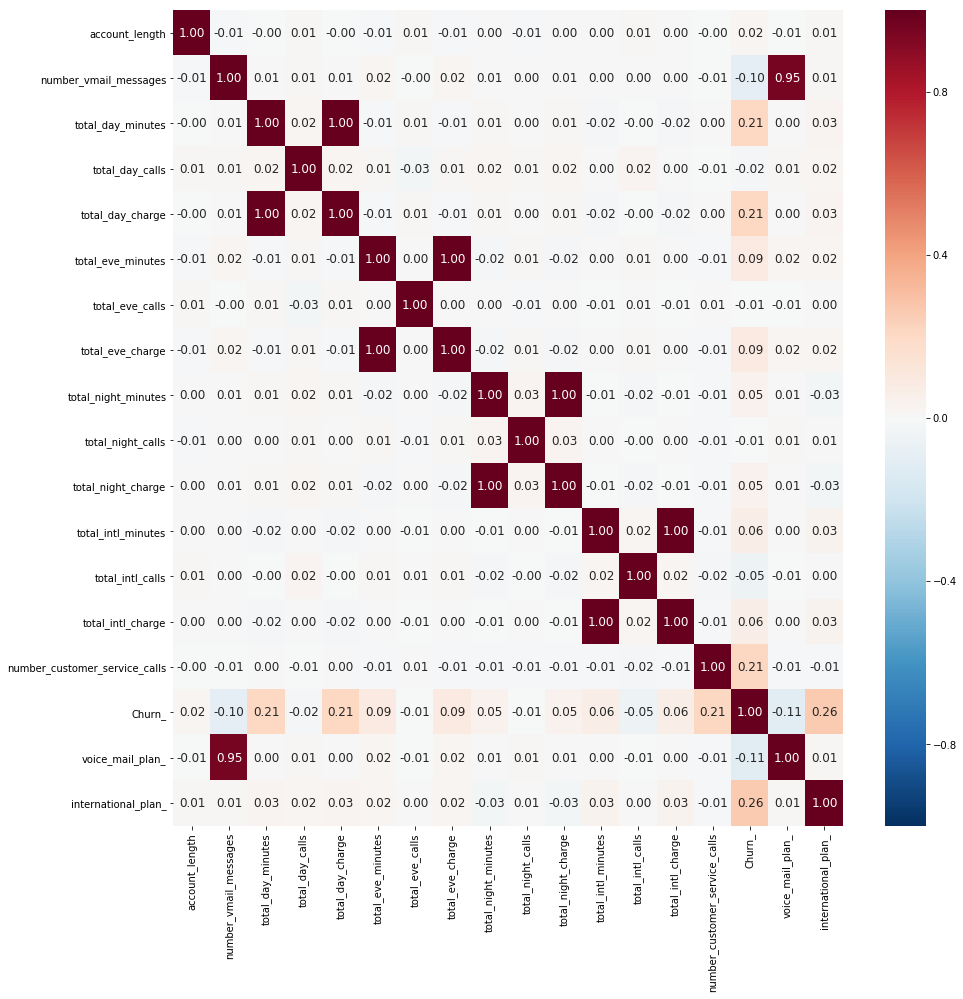

In [80]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cr,  vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", annot_kws={"size": 12}, ax= ax, cmap="RdBu_r")
plt.show()

In [81]:
CV_data.head()

Row(account_length=128, number_vmail_messages=25, total_day_minutes=265.1, total_day_calls=110, total_day_charge=45.07, total_eve_minutes=197.4, total_eve_calls=99, total_eve_charge=16.78, total_night_minutes=244.7, total_night_calls=91, total_night_charge=11.01, total_intl_minutes=10.0, total_intl_calls=3, total_intl_charge=2.7, number_customer_service_calls=1, Churn_=0.0, voice_mail_plan_=1.0, international_plan_=0.0)

In [82]:
#FILTER OF NUMERICAL VARIABLES
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double' or t[1] == 'bigint']
numeric_features

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'Churn_',
 'voice_mail_plan_',
 'international_plan_']

In [83]:
#select a sample
sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()
sampled_data.shape

(469, 18)

In [85]:
import seaborn as sns
sns.set(style="ticks")

col_1 = list(['account_length', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'Churn_'])

col_2 = list(['total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'Churn_', 'voice_mail_plan_',
       'international_plan_'])


/home/erikapat/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/erikapat/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/erikapat/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/erikapat/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **pas

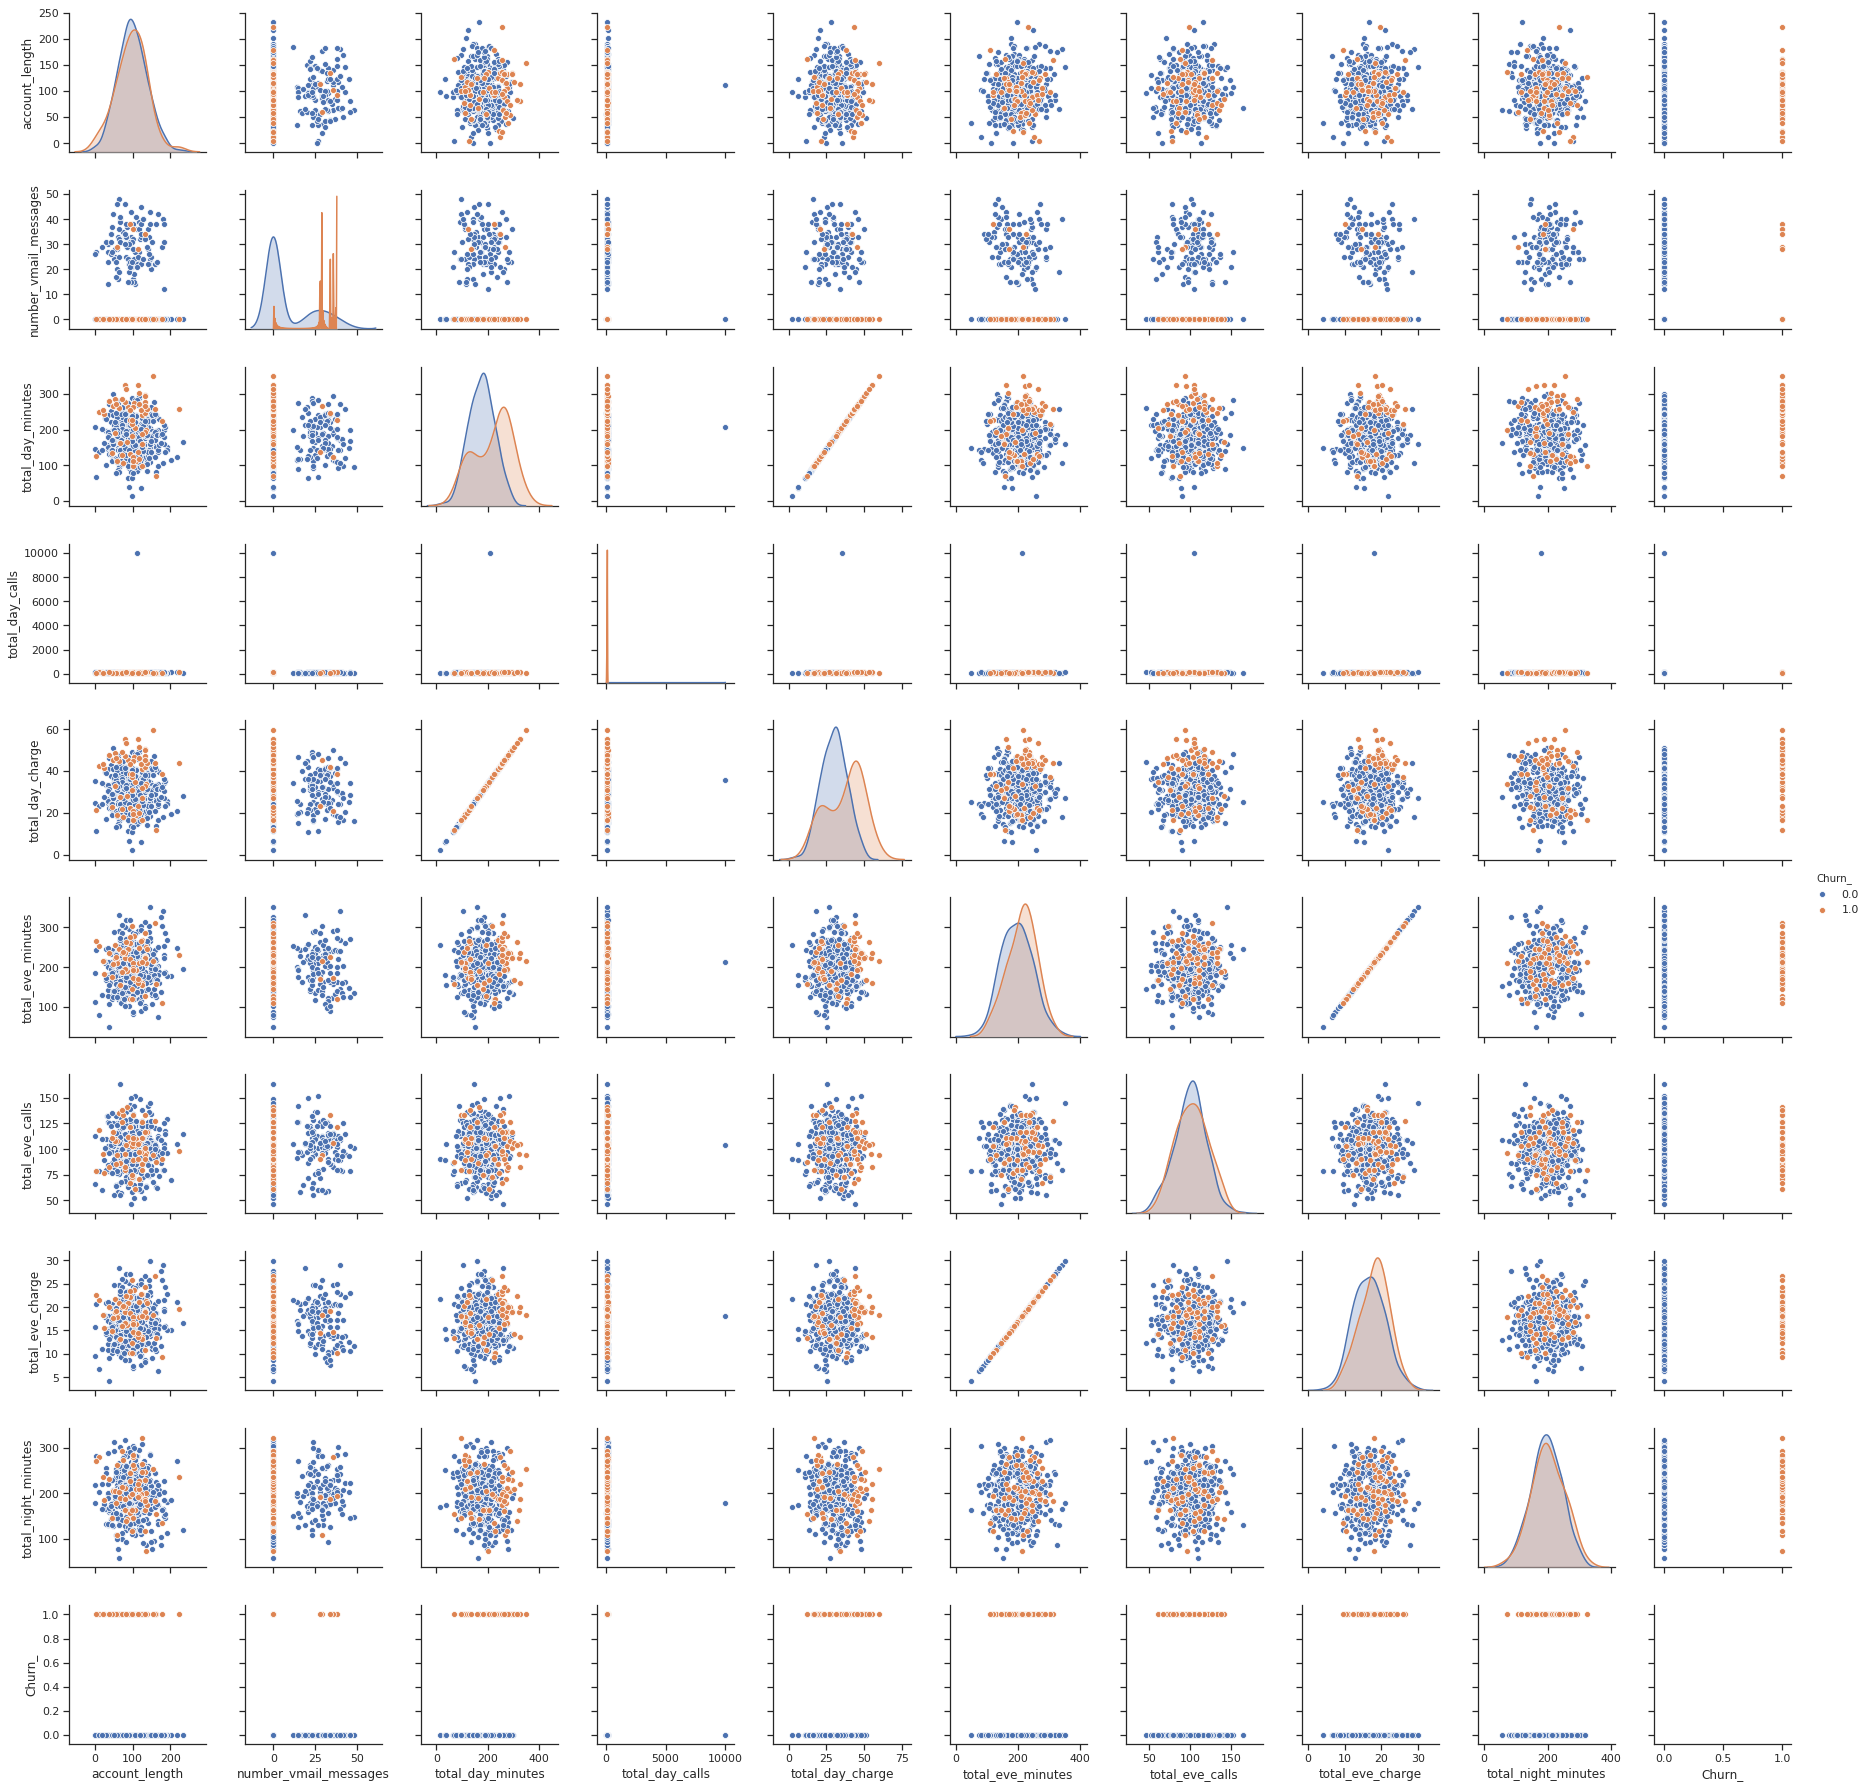

In [86]:
df = sampled_data #.toPandas()
sns.pairplot(df.loc[:, col_1], hue="Churn_")#

/home/erikapat/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/erikapat/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/erikapat/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/erikapat/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **pas

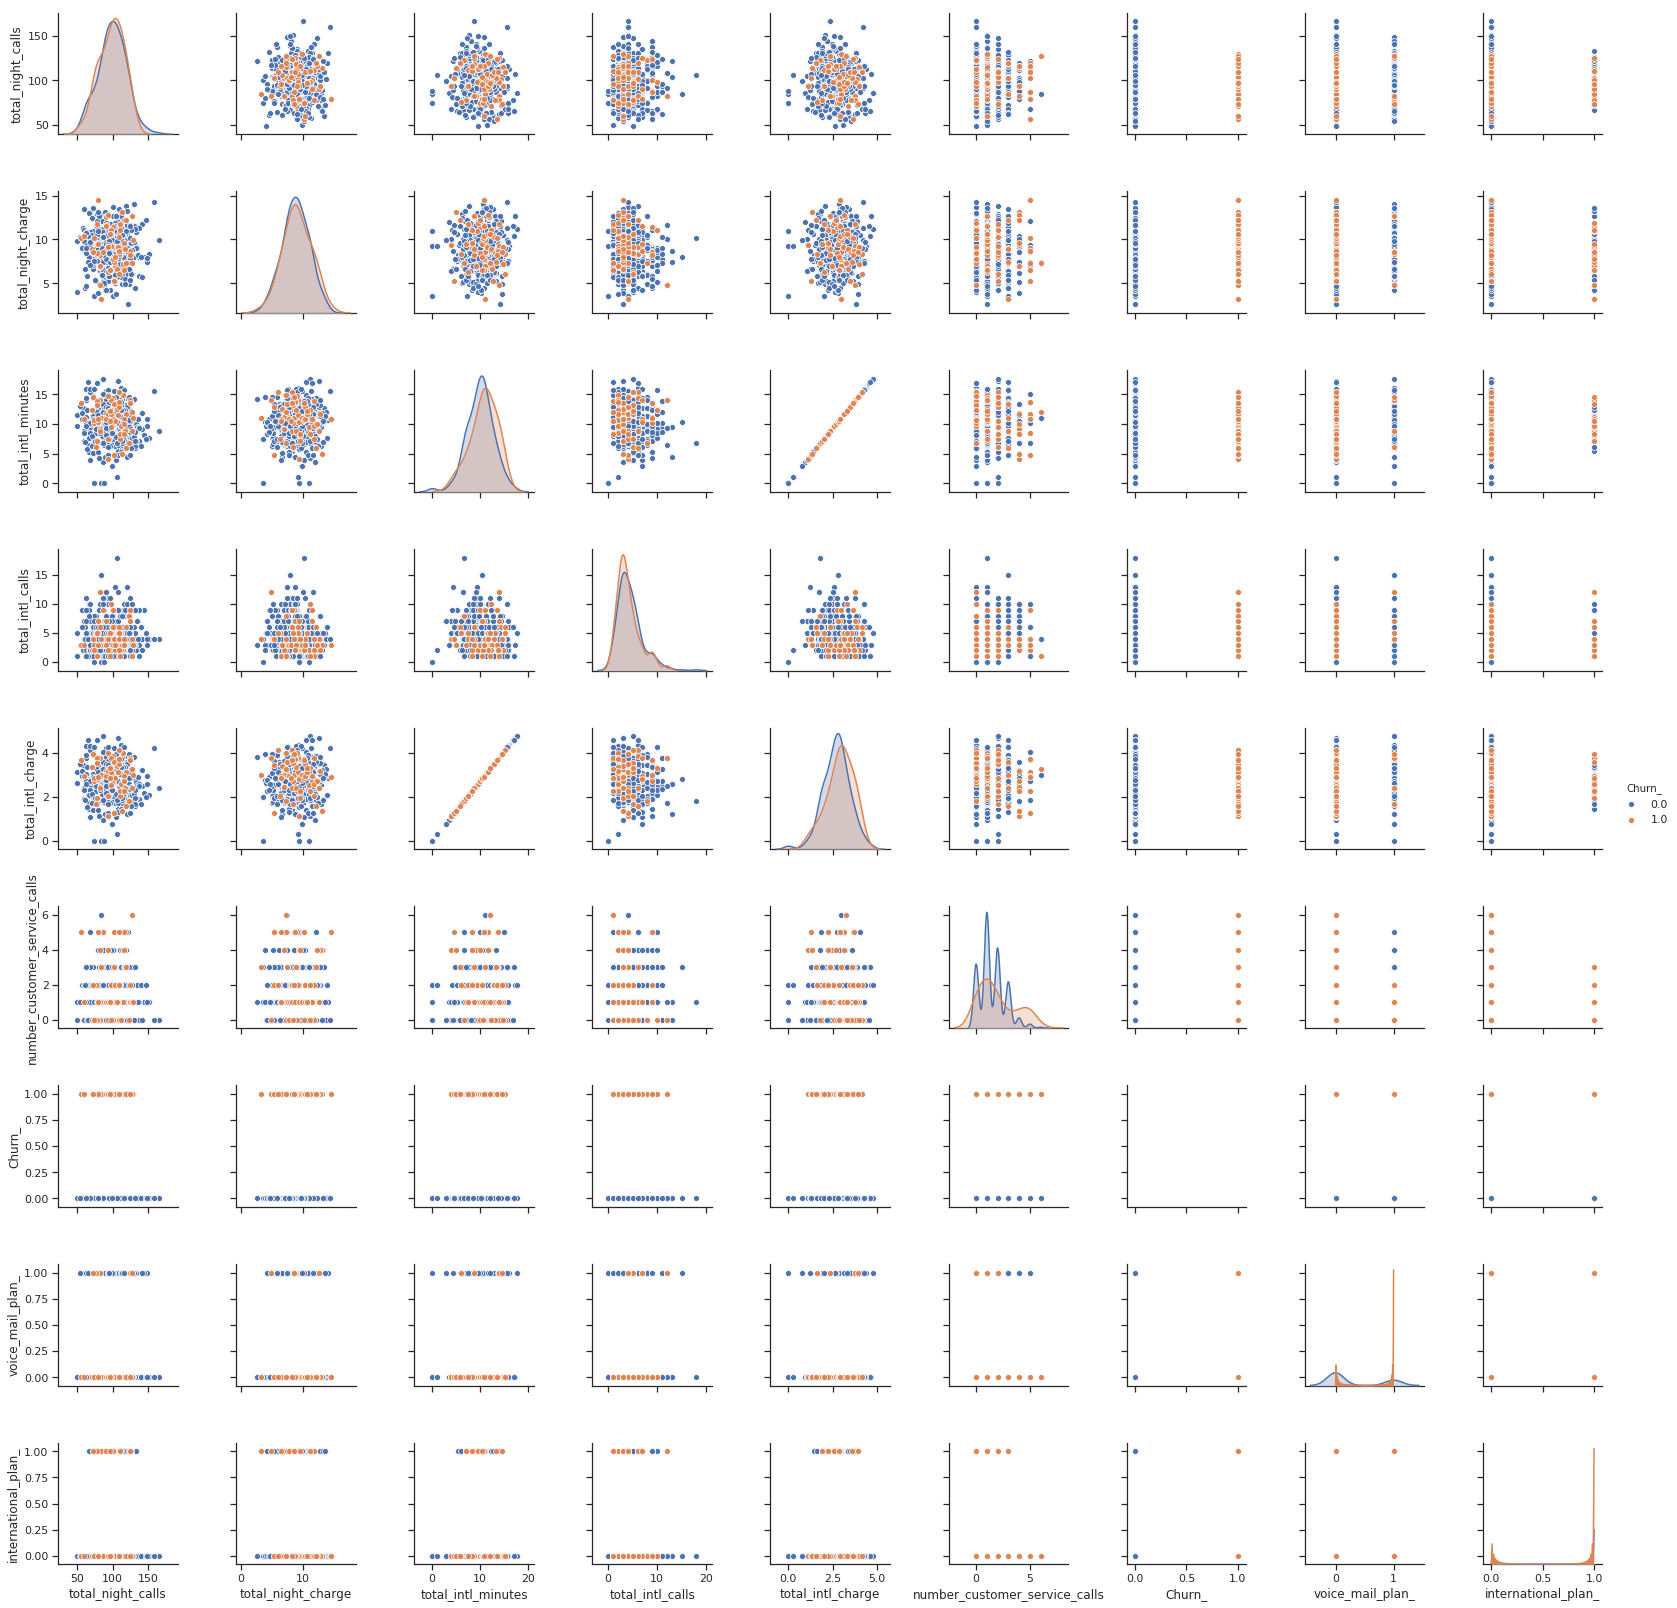

In [87]:
df = sampled_data #.toPandas()
sns.pairplot(df.loc[:, col_2], hue="Churn_")#

In [88]:
type(CV_data)

pyspark.sql.dataframe.DataFrame

In [89]:
#joint data again
CV_data_ = pd.concat([CV_data.toPandas(), CV_data_dummies], axis=1)


In [90]:
CV_data = spark.createDataFrame(CV_data_)

In [91]:
# divide the data

CV_data.groupBy('Churn_').count().show()




+------+-----+
|Churn_|count|
+------+-----+
|   0.0| 4293|
|   1.0|  707|
+------+-----+



In [92]:
CV_data.groupby('Churn_').count().toPandas()


,Churn_,count
0,0.0,4293
1,1.0,707


In [93]:
#Estratificamos
#count0 = CV_data.groupby('Churn_').count().where(col("Churn_") == 0) #.select(col("count")).head()[0]
#count1 = CV_data.groupby('Churn_').count().where(col("Churn_") == 1).select(col("count")).head()[0]

stratified_CV_data = CV_data.sampleBy('Churn_', fractions={0: 707./4293, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn_').count().toPandas()


,Churn_,count
0,0.0,710
1,1.0,707


In [94]:
stratified_CV_data.toPandas().head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,141,37,258.6,84,43.96,222.0,111,18.87,326.4,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,65,0,129.1,137,21.95,228.5,83,19.42,208.8,111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,168,0,128.8,96,21.90,104.9,71,8.92,141.1,128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare data
In this subsection you will split your data into:

* train data set
* test data set
* predict data set



In [95]:
#(train_data, test_data, predict_data) = df_complete.randomSplit([0.8, 0.18, 0.02], 24)

#print("Number of records for training: " + str(train_data.count()))
#print("Number of records for evaluation: " + str(test_data.count()))
#print("Number of records for prediction: " + str(predict_data.count()))

In [96]:
#from pyspark.sql.types import DoubleType
#from pyspark.sql.functions import UserDefinedFunction

#binary_map = {'Yes':1.0, 'No':0.0, 'True':1.0, 'False':0.0}
#toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())

#CV_data = CV_data.drop('State').drop('Area code') \
#    .drop('Total day charge').drop('Total eve charge') \
#    .drop('Total night charge').drop('Total intl charge') \
#    .withColumn('Churn', toNum(CV_data['Churn'])) \
#    .withColumn('International plan', toNum(CV_data['International plan'])) \
#    .withColumn('Voice mail plan', toNum(CV_data['Voice mail plan'])).cache()

#final_test_data = final_test_data.drop('State').drop('Area code') \
#    .drop('Total day charge').drop('Total eve charge') \
#    .drop('Total night charge').drop('Total intl charge') \
#    .withColumn('Churn', toNum(final_test_data['Churn'])) \
#    .withColumn('International plan', toNum(final_test_data['International plan'])) \
#    .withColumn('Voice mail plan', toNum(final_test_data['Voice mail plan'])).cache()

In [97]:
X = CV_data.toPandas()
y = X.loc[:, 'Churn_']
#XX = X.drop('Churn_') \
X = X.drop(columns = ['Churn_'], axis=1)


In [98]:
# EXAMPLE : transfor numpy array in spark data.frame
col_X = list(X)
col_y = list(['Churn_'])


#from pyspark.ml.linalg import Vectors
#from pyspark.ml.feature import VectorAssembler

#spark.createDataFrame(pd.DataFrame([X,y], columns = [col_X, col_y])).show()


## UNDERSAMPLIG - OVERSAMPLIG()

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

https://www.kaggle.com/qianchao/smote-with-imbalance-data   

In [99]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


#cpip install imblearn

In [100]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))



Before OverSampling, the shape of train_X: (3500, 71)
Before OverSampling, the shape of train_y: (3500,) 

Before OverSampling, counts of label '1': 505
Before OverSampling, counts of label '0': 2995 



## SMOTE

In [101]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (5990, 71)
After OverSampling, the shape of train_y: (5990,) 

After OverSampling, counts of label '1': 2995
After OverSampling, counts of label '0': 2995


In [102]:
# numpy to dataframe to pyspark.data.frame
col_X = list(col_X)
cols = col_X + col_y
print(cols)


['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'voice_mail_plan_', 'international_plan_', '408', '415', '510', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'Churn_']


In [103]:
#combine data TRAIN
X_train_res_ = pd.DataFrame(X_train_res, columns= col_X)
y_train_res_ = pd.DataFrame(y_train_res, columns= col_y)
#X_train_res_.head()
#y_train_res_.head()

train_1 = pd.DataFrame( np.concatenate( (X_train_res_, y_train_res_), axis=1 ), columns= cols )
#train_1.head()
train = spark.createDataFrame(train_1)
#train.toPandas().head()
type(train)

pyspark.sql.dataframe.DataFrame

In [104]:

#combine data Test
X_test_res_ = pd.DataFrame(X_test, columns= col_X)
y_test_res_ = pd.DataFrame(y_test.ravel(), columns= col_y)

#y_test_res_.head()

test_1 = pd.DataFrame( np.concatenate( (X_test_res_, y_test_res_), axis=1 ), columns= cols )
#test_1.head()
#test_1.head()
test = spark.createDataFrame(test_1)
test.toPandas().head()


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,Churn_
0,84.0,0.0,181.5,129.0,30.86,130.7,112.0,11.11,186.5,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,76.0,35.0,273.7,94.0,46.53,153.3,101.0,13.03,259.0,109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,97.0,0.0,169.2,91.0,28.76,224.6,122.0,19.09,108.0,115.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80.0,0.0,275.4,89.0,46.82,186.7,66.0,15.87,201.3,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,121.0,0.0,150.7,105.0,25.62,197.3,133.0,16.77,169.0,116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PIPELINES Assembler

In [105]:
numeric_features = cols
numeric_features

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'voice_mail_plan_',
 'international_plan_',
 '408',
 '415',
 '510',
 'AK',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY',
 'Churn_']

In [106]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer

In [107]:

label_indexer = StringIndexer(inputCol = 'Churn_', outputCol = 'label') 
reduced_numeric_cols = numeric_features[0:len(numeric_features)-1]
 
assembler = VectorAssembler(
    inputCols = reduced_numeric_cols,
    outputCol = 'features')
assembler

VectorAssembler_0d769ba3767d

## LOGISTIC REGRESSION

#Parameters

* **Threshold** :probability threshold for yes/no decision
* **maxIter** : max number of interations
* **regParam** regularization multiplier for overfitting prevention
* **elasticNetParam** L1 vs L2 (REGULARIZATION METHOS)

The elastic net parameter α set to 1, it is equivalent to a Lasso model. On the other hand, if α is set to 0, the trained model reduces to a ridge regression model.

* **Standardization** Scales numbers based on (xi-mean(xi)/sd(xi))

In [108]:
standardization = False
elastic_net_param = 0.0
reg_param = .01
max_iter = 20
family = "binomial"


from pyspark.ml.classification import LogisticRegression
LRclassifier = LogisticRegression(labelCol = 'label', featuresCol = 'features',
                                 maxIter = max_iter, regParam = reg_param, elasticNetParam = elastic_net_param, 
                        standardization = standardization, family = family)
LRpipeline = Pipeline(stages=[label_indexer, assembler, LRclassifier])


In [109]:
# coefficients
LRmodel = LRpipeline.fit(train)
LRmodel
#(1)
lrm = LRmodel.stages[-1]
#lrm.coefficients

#(2)
#[stage.coefficients for stage in LRmodel.stages if hasattr(stage, "coefficients")]

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrm.coefficients))
print("Intercept: " + str(lrm.intercept))

Coefficients: [0.0008450193439402986,-0.033248393328424546,0.006141069203577232,-0.003960138773933766,0.034644978920472386,0.003293493929821092,-0.0058208074136034,0.03348789946832466,0.0019202443088391326,-0.009045875070889277,0.038276659396789106,0.05611644541970576,-0.09801888109186709,-0.025680685846385668,0.6427542960169388,0.04469556103469609,1.543395148878593,-0.04760452929854102,-0.2009114698083911,-0.09864509785762923,-0.004581133453302062,-0.1095365909891612,-0.029393196584087497,-0.04743542820556648,0.3623527051743464,-0.19148520541559205,0.009611801124662863,0.03910872293806721,-0.046100493490240514,0.031481633720186517,-0.1860142667103237,-0.3030948674099668,-0.08176989960154336,-0.2247367121445788,-0.17981562374833943,0.03289170971928814,0.039508934238032,0.03407307939312912,-0.042510723893112834,-0.014455267398784083,0.13259614802470435,0.0788127160068603,0.10406247246233953,0.1105079107889203,-0.10102448436338171,0.07203824919440724,0.30337261245873864,-0.12532396330403

## OPCION 1

In [110]:
# Make predictions.
predictions = LRmodel.transform(test)
#predictions
# Select example rows to display.
predictions.select("features", "rawPrediction","probability","prediction").show(5)

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(71,[0,2,3,4,5,6,...|[1.856798207045,-...|[0.86492331633487...|       0.0|
|(71,[0,1,2,3,4,5,...|[1.85173171017217...|[0.86433029742057...|       0.0|
|(71,[0,2,3,4,5,6,...|[1.27586381393188...|[0.78174488354956...|       0.0|
|(71,[0,2,3,4,5,6,...|[-1.8273216587454...|[0.13855764908197...|       1.0|
|(71,[0,2,3,4,5,6,...|[2.63307442744315...|[0.93296009732990...|       0.0|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [111]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.247333


In [112]:
#Predicciones sobre el test
LRpredictions = LRmodel.transform(test)

In [113]:
LR =  LRmodel.stages[-1]
print(LR)  # summary only

LogisticRegressionModel: uid = LogisticRegression_52828c96896f, numClasses = 2, numFeatures = 71


In [114]:
LR_selected_predictions = LRpredictions.select('prediction', 'probability','features')
#LR_selected_predictions.toPandas()
LR_selected_predictions.select("prediction").groupBy("prediction").count().show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0.0       |1035 |
|1.0       |465  |
+----------+-----+



In [115]:
## OPCION 2

In [116]:
import pyspark
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, when
from pyspark.sql import SparkSession

In [117]:
evaluator = BinaryClassificationEvaluator()
LRaccuracy = evaluator.evaluate(LRpredictions)
LRaccuracy
#print ("Logistic Regression Accuracy = %g " % (LRaccuracy))
#print("Logistic Regression Test Error = %g " % (1.0 - LRaccuracy))

0.8115264916322151

In [118]:
#Curva ROC
lrModel = LRmodel.stages[2]
trainingSummary = lrModel.summary

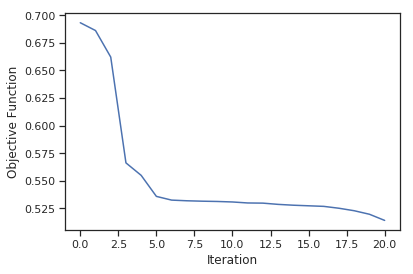

In [119]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

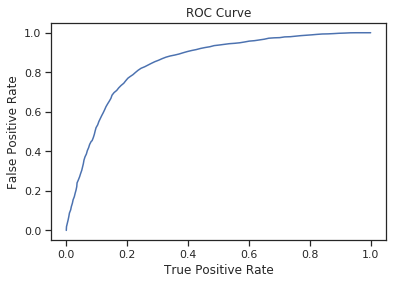

In [120]:
#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [121]:
# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)


+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
| 6.67779632721202E-4|0.019031719532554257|
| 0.00333889816360601| 0.03606010016694491|
|0.006010016694490818| 0.05308848080133556|
|0.008347245409015025| 0.07045075125208682|
+--------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.84737143987893


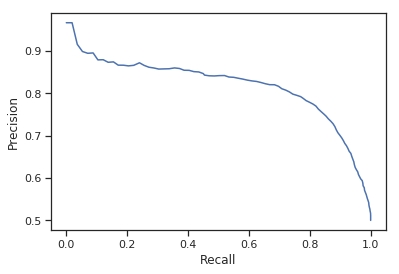

In [122]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

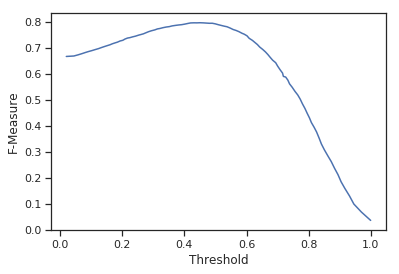

In [123]:
# Set the model threshold to maximize F-Measure
#trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [125]:

#class_names
class_temp =['FALSE', 'TRUE']

In [126]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

y_true
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[981, 317],
       [ 54, 148]])

Confusion matrix, without normalization
[[981 317]
 [ 54 148]]


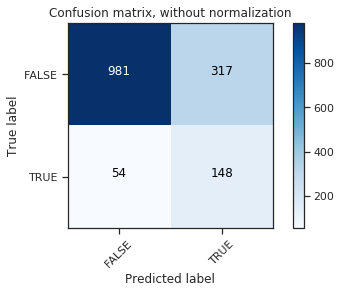

In [127]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.75577812 0.24422188]
 [0.26732673 0.73267327]]


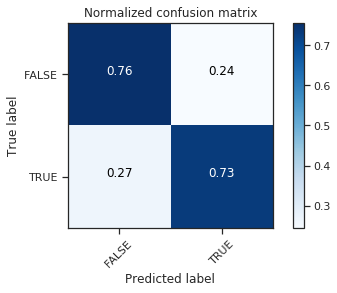

In [128]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [129]:
# Make predictions.
predictions = LRmodel.transform(test)
#predictions
# Select example rows to display.
predictions.select("Churn_", "features", "rawPrediction","probability","prediction").show(5)

+------+--------------------+--------------------+--------------------+----------+
|Churn_|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|   0.0|(71,[0,2,3,4,5,6,...|[1.856798207045,-...|[0.86492331633487...|       0.0|
|   0.0|(71,[0,1,2,3,4,5,...|[1.85173171017217...|[0.86433029742057...|       0.0|
|   0.0|(71,[0,2,3,4,5,6,...|[1.27586381393188...|[0.78174488354956...|       0.0|
|   1.0|(71,[0,2,3,4,5,6,...|[-1.8273216587454...|[0.13855764908197...|       1.0|
|   0.0|(71,[0,2,3,4,5,6,...|[2.63307442744315...|[0.93296009732990...|       0.0|
+------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [130]:
tp = float(predictions.filter("prediction == 1.0 AND Churn_==1.0").count())
tn = float(predictions.filter("prediction == 0.0 AND Churn_==0.0").count())
fp = float(predictions.filter("prediction == 1.0 AND Churn_==0.0").count())
fn = float(predictions.filter("prediction == 0.0 AND Churn_==1.0").count())
metrics=spark.createDataFrame([
        ("TP",tp),
        ("TN",tn),
        ("FP",fp),
        ("FN",fn),
        ("Percision",tp/(tp+fp)),
        ("Recall",tp/(tp+fn)) ],["Metric","Value"])
metrics.show()


+---------+-------------------+
|   Metric|              Value|
+---------+-------------------+
|       TP|              148.0|
|       TN|              981.0|
|       FP|              317.0|
|       FN|               54.0|
|Percision|0.31827956989247314|
|   Recall| 0.7326732673267327|
+---------+-------------------+



## CROSS VALIDATION

In [131]:
def evaluate_model(results):
    """ Prints the confusion matrix, f1-score, precision, recall and accuracy of the model """
    tn = results.filter((results.prediction == 0)&(results.label==0)).count() * 1.0 # true negative
    fp = results.filter((results.prediction == 1)&(results.label==0)).count() * 1.0 # false positive
    fn = results.filter((results.prediction == 0)&(results.label==1)).count() * 1.0 # false negative
    tp = results.filter((results.prediction == 1)&(results.label==1)).count() * 1.0 # true positive
    print("Confusion Matrix")
    print("TN:{} | FP:{}".format(tn,fp))
    print("FN:{} | TP: {}".format(fn, tp))
    print("--------------")
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    #print(precision)
    #print(recall)
    f1 = 2.0 * (precision * recall)/(precision + recall)
    print("F1-Score: {}".format(f1))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("Accuracy: {}".format(accuracy))

In [132]:
help(LogisticRegression)

Help on class LogisticRegression in module pyspark.ml.classification:

class LogisticRegression(pyspark.ml.wrapper.JavaEstimator, pyspark.ml.param.shared.HasFeaturesCol, pyspark.ml.param.shared.HasLabelCol, pyspark.ml.param.shared.HasPredictionCol, pyspark.ml.param.shared.HasMaxIter, pyspark.ml.param.shared.HasRegParam, pyspark.ml.param.shared.HasTol, pyspark.ml.param.shared.HasProbabilityCol, pyspark.ml.param.shared.HasRawPredictionCol, pyspark.ml.param.shared.HasElasticNetParam, pyspark.ml.param.shared.HasFitIntercept, pyspark.ml.param.shared.HasStandardization, pyspark.ml.param.shared.HasThresholds, pyspark.ml.param.shared.HasWeightCol, pyspark.ml.param.shared.HasAggregationDepth, pyspark.ml.util.JavaMLWritable, pyspark.ml.util.JavaMLReadable)
 |  Logistic regression.
 |  This class supports multinomial logistic (softmax) and binomial logistic regression.
 |  
 |  >>> from pyspark.sql import Row
 |  >>> from pyspark.ml.linalg import Vectors
 |  >>> bdf = sc.parallelize([
 |  ...    

In [133]:

paramGrid = ParamGridBuilder() \
            .addGrid(LRclassifier.regParam,[0.0, 0.05, 0.1]) \
            .build()  

# Create ParamGrid for Cross Validation
#paramGrid = (ParamGridBuilder()
#             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
#             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
#             .addGrid(lr.maxIter, [1, 5, 10])
#             .build())

cv_lr = CrossValidator(estimator=LRpipeline,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=\
                   BinaryClassificationEvaluator(metricName=\
                                "areaUnderPR"),\
                       numFolds=5, seed=42) 

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
cvModel_lr = cv_lr.fit(train)
lr_results = cvModel_lr.transform(test)
lr_results
evaluate_model(lr_results)

Confusion Matrix
TN:998.0 | FP:300.0
FN:59.0 | TP: 143.0
--------------
F1-Score: 0.4434108527131783
Precision: 0.3227990970654628
Recall: 0.7079207920792079
Accuracy: 0.7606666666666667


In [134]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(lr_results)

0.8062518116218393

In [135]:
params = [{p.name: v for p, v in m.items()} for m in cvModel_lr.getEstimatorParamMaps()]
for ps, metric in zip(params, cvModel_lr.avgMetrics):
    print("Reg Param: {} ... areaUnderPR: {}".format(ps['regParam'], metric))

Reg Param: 0.0 ... areaUnderPR: 0.8386097000062304
Reg Param: 0.05 ... areaUnderPR: 0.7900861413593401
Reg Param: 0.1 ... areaUnderPR: 0.7786002403300085


## OTRA FORMA DE HACER LAS COSAS 

In [136]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [ ]:
parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

In [ ]:
clf.best_params_

In [ ]:
lr1 = LogisticRegression(C=4,penalty='l1', verbose=5)
lr1.fit(X_train_res, y_train_res.ravel())

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#y_train_pre = lr1.predict(X_train)
#cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

y_test_pre = lr1.predict(X_test)
cnf_matrix_tra = confusion_matrix(y_test, y_test_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())

In [ ]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
LRaccuracy = evaluator.evaluate(LRpredictions)
print ("Logistic Regression Accuracy = %g " % (LRaccuracy))
#print("Logistic Regression Test Error = %g " % (1.0 - LRaccuracy))

## BIBLIOGRAFY 

https://towardsdatascience.com/customer-churn-prediction-with-pyspark-on-ibm-watson-studio-aws-and-databricks-de57a2ffb25b

https://github.com/joshxinjie/sparkify_customer_churn/blob/master/Sparkify_IBM.ipynb

https://runawayhorse001.github.io/LearningApacheSpark/classification.html

https://github.com/joshxinjie/sparkify_customer_churn/blob/master/Sparkify_IBM.ipynb

https://wesslen.github.io/twitter/predicting_twitter_profile_location_with_pyspark/

## CHALLENGE ()

3 Modelado
A la hora de construir un modelo para predecir el ​ churn ​ para el juego de datos, cubre al menos una de las siguientes opciones.

1. Regresión logística + regularización ridge + regularización lasso
2. Regresión logística + logística con polinomio de orden 2 + regularización a elegir (ORDEN 2 = ITERACTIONS)
3. Regresión logística + ​ random forest ​ o modelo ​ ensemble ​ a elegir

Identifica las variables más significativas para la predicción.

Para evaluar la precisión del modelo, establece:
* Medida de precisión
* Estrategia de validación para garantizar resultado generalizable
* Equilibrio entre tasa de falsos positivos y falsos negativos 
* Establece brevemente una comparación entre modelos y determina las variables más significativas para la predicción.


## Linear Support Vector Machines (SVMs)


https://spark.apache.org/docs/2.3.0/mllib-linear-methods.html#linear-support-vector-machines-svms


In [137]:
from pyspark.ml.classification import LinearSVC
from pyspark.mllib.classification import SVMWithSGD, SVMModel
#scaler = StandardScaler(inputCol="FeaturesVec", outputCol="features", withMean=True, withStd=True)

# Support Vector Machine Classifier
svc = LinearSVC(maxIter=10)
#pipeline_svc = Pipeline(stages=[assembler, scaler, svc])
pipeline_svc = Pipeline(stages=[label_indexer, assembler, svc])


# Linear Support Vector Machine
# Using L2 regularization
paramGrid = ParamGridBuilder() \
    .addGrid(svc.regParam,[0.0, 0.05, 0.1, 0.2]) \
    .build()

cv_svc = CrossValidator(estimator=pipeline_svc,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_svc = cv_svc.fit(train)

In [138]:
svc_results = cvModel_svc.transform(test)
evaluate_model(svc_results)

Confusion Matrix
TN:845.0 | FP:453.0
FN:49.0 | TP: 153.0
--------------
F1-Score: 0.3787128712871287
Precision: 0.2524752475247525
Recall: 0.7574257425742574
Accuracy: 0.6653333333333333


In [139]:
params = [{p.name: v for p, v in m.items()} for m in cvModel_svc.getEstimatorParamMaps()]
for ps, metric in zip(params, cvModel_svc.avgMetrics):
    print("Reg Param: {} ... areaUnderPR: {}".format(ps['regParam'], metric)) #areaUnderROC areaUnderPR

Reg Param: 0.0 ... areaUnderPR: 0.816668477329975
Reg Param: 0.05 ... areaUnderPR: 0.8170627507573496
Reg Param: 0.1 ... areaUnderPR: 0.8154708390614575
Reg Param: 0.2 ... areaUnderPR: 0.8159448134513696


In [140]:
cvModel_svc.getEstimatorParamMaps()

[{Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.0},
 {Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.05},
 {Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.2}]

In [141]:
LRmodel = pipeline_svc.fit(train)
predictions = LRmodel.transform(train)

In [142]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.764440734557596


In [143]:
#svc_results.toPandas().head()
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(svc_results, {evaluator.metricName: "areaUnderPR"})))

Test: Area Under ROC: 0.2381865830147371


## Random Forest

In [144]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
#pipeline_svc = Pipeline(stages=[assembler, scaler, svc])
pipeline_rf = Pipeline(stages=[label_indexer, assembler, rf])

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

In [145]:
cv_rf = CrossValidator(estimator=pipeline_rf,\
                       estimatorParamMaps=paramGrid,\
                       evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),\
                       numFolds=5,\
                       seed=42
                      )
cvModel_rf = cv_svc.fit(train)

In [146]:
rf_results = cvModel_rf.transform(test)
evaluate_model(rf_results)

Confusion Matrix
TN:845.0 | FP:453.0
FN:49.0 | TP: 153.0
--------------
F1-Score: 0.3787128712871287
Precision: 0.2524752475247525
Recall: 0.7574257425742574
Accuracy: 0.6653333333333333


In [147]:
params = [{p.name: v for p, v in m.items()} for m in cvModel_rf.getEstimatorParamMaps()]
for ps, metric in zip(params, cvModel_rf.avgMetrics):
    print("Reg Param: {} ... areaUnderPR: {}".format(ps['regParam'], metric)) #areaUnderROC areaUnderPR

Reg Param: 0.0 ... areaUnderPR: 0.8166684773299749
Reg Param: 0.05 ... areaUnderPR: 0.8170627507573496
Reg Param: 0.1 ... areaUnderPR: 0.8154708390614575
Reg Param: 0.2 ... areaUnderPR: 0.8159448134513696


In [148]:
cvModel_rf.getEstimatorParamMaps()

[{Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.0},
 {Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.05},
 {Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='LinearSVC_08f06fcf189d', name='regParam', doc='regularization parameter (>= 0).'): 0.2}]

## Gradient Boosted Trees

In [149]:
from pyspark.ml.classification import GBTClassifier

BT = GBTClassifier(labelCol="label", featuresCol="features")
#pipeline_svc = Pipeline(stages=[assembler, scaler, svc])
pipeline_BT = Pipeline(stages=[label_indexer, assembler, BT])

# Gradient Boosted Trees
# not performing grid search for gbt because it will be too memomry intensive
# will use optimal paramters from the samll dataset
paramGrid = ParamGridBuilder() \
            .addGrid(BT.minInstancesPerNode,[5]) \
            .addGrid(BT.maxDepth,[7])\
            .addGrid(BT.subsamplingRate,[0.75])\
            .build()

cv_gbt = CrossValidator(estimator=pipeline_BT,\
                        estimatorParamMaps=paramGrid,\
                        evaluator=BinaryClassificationEvaluator(metricName="areaUnderPR"),\
                        numFolds=5,\
                        seed=42
                       )
cvModel_gbt = cv_gbt.fit(train)


In [150]:
gbt_results = cvModel_gbt.transform(test)
evaluate_model(gbt_results)

Confusion Matrix
TN:1198.0 | FP:100.0
FN:63.0 | TP: 139.0
--------------
F1-Score: 0.6303854875283447
Precision: 0.5815899581589958
Recall: 0.6881188118811881
Accuracy: 0.8913333333333333


In [151]:
params = [{p.name: v for p, v in m.items()} for m in cvModel_gbt.getEstimatorParamMaps()]
for ps, metric in zip(params, cvModel_gbt.avgMetrics):
    print("minInstancesPerNode:{} ... subsamplingRate:{} ... maxDepth:{} ... areaUnderPR: {}".format(ps['minInstancesPerNode'], ps['subsamplingRate'], ps['maxDepth'], metric))
    #print("subsamplingRate: {} ... areaUnderPR: {}".format(ps['subsamplingRate'], metric))

minInstancesPerNode:5 ... subsamplingRate:0.75 ... maxDepth:7 ... areaUnderPR: 0.9693586691134652


In [152]:
cvModel_gbt_best = cvModel_gbt.bestModel
importances = cvModel_gbt_best.stages[-1].featureImportances.toArray()
len(importances)
importances

array([1.87930567e-03, 3.52699746e-02, 1.54388885e-01, 1.80231501e-03,
       1.12103436e-01, 2.72362316e-02, 9.16899644e-04, 1.28776584e-02,
       4.72958348e-03, 1.70307311e-03, 9.69223459e-03, 4.43831949e-03,
       6.55339253e-03, 1.09002629e-02, 1.47340908e-01, 5.11805796e-02,
       1.54407913e-01, 6.23167233e-02, 1.01062722e-01, 4.64270950e-02,
       6.10830122e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.34677882e-03, 2.50201074e-04, 0.00000000e+00, 0.00000000e+00,
       7.31962784e-04, 0.00000000e+00, 0.00000000e+00, 1.27145682e-03,
       0.00000000e+00, 6.90348300e-04, 3.64363043e-04, 1.77356220e-04,
       1.33052611e-03, 2.78996584e-04, 7.40592851e-04, 7.80193170e-04,
       3.09973355e-03, 2.85322352e-03, 0.00000000e+00, 3.47044794e-04,
       0.00000000e+00, 9.89696113e-04, 3.63613717e-04, 0.00000000e+00,
       1.37338043e-04, 7.48994969e-04, 3.64160714e-04, 3.14058452e-03,
       0.00000000e+00, 1.06947096e-03, 1.50573598e-03, 3.14708402e-04,
      

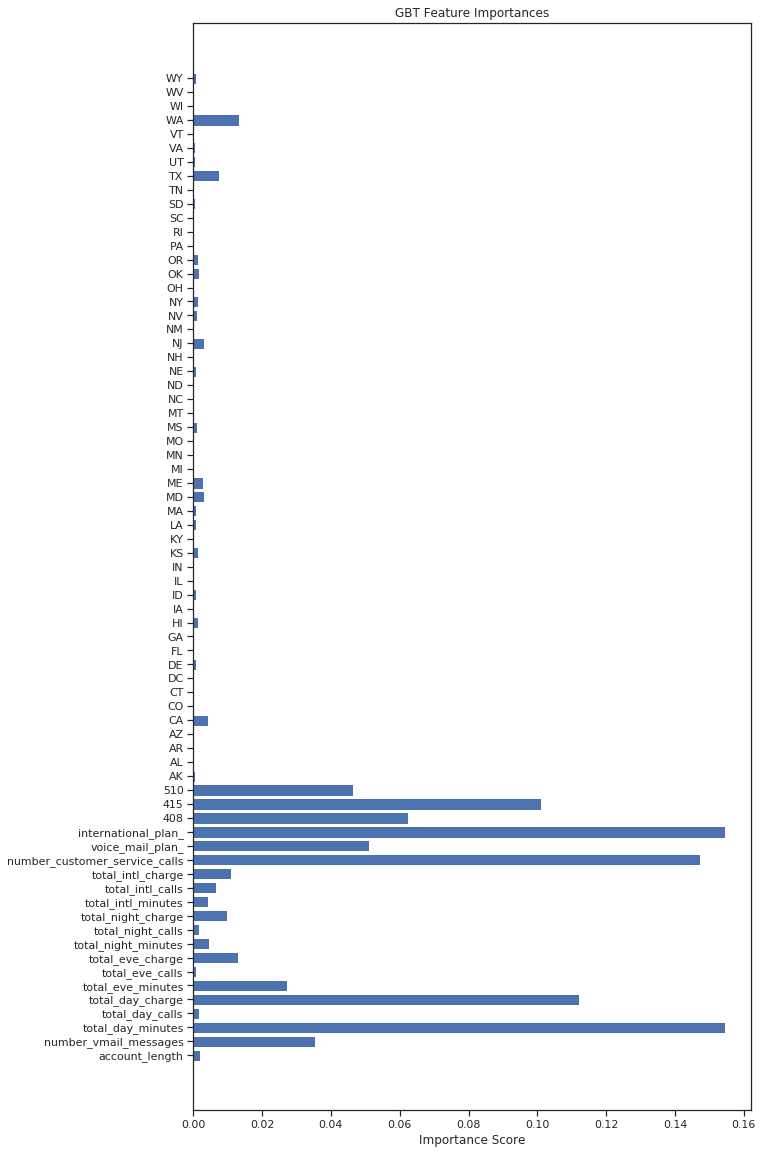

In [154]:
inputColumns=cols[:-1]
y_pos = np.arange(len(inputColumns))
#y_pos

fig, ax = plt.subplots(figsize=(10,20))
ax.barh(y_pos, importances);
plt.yticks(y_pos, inputColumns);
plt.xlabel('Importance Score');
plt.title('GBT Feature Importances');

## no ejecutar ---------------------------------------------------------------------------------------------------------

## Decision Tree

In [155]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingData)
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingData)

predictions = dtModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("body","displayName","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

NameError: name 'trainingData' is not defined

## NAIVE BAYES

In [ ]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# train the model
model = nb.fit(trainingData)

In [ ]:
# select example rows to display.
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("body","displayName","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 30)

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

## MULTILAYER PERCEPTRON

In [ ]:

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load training data
data = spark.read.format("libsvm")\
    .load("data/mllib/sample_multiclass_classification_data.txt")

# Split the data into train and test
splits = data.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [4, 5, 4, 3]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

## MÁS En...
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#gradient-boosted-tree-classifier

## LogisticRegressionWithLBFGS 

A quick glance at the docs for LogisticRegressionWithLBFGS indicates that it uses feature scaling and L2-Regularization by default. I suspect that R's glm is returning a maximum likelihood estimate of the model while Spark's LogisticRegressionWithLBFGS is returning a regularized model estimate. Note how the estimated model weights of the Spark model are all smaller in magnitude than those in the R model.

https://www.csie.ntu.edu.tw/~cjlin/papers/spark-liblinear/spark-liblinear.pdf

## EJEMPLO CON DETALLE DE LAS MÉTRICAS

https://github.com/adornes/spark_python_ml_examples/blob/master/spark/kaggle/allstate_claims_severity_random_forest_regressor.py